In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os
import json
from torch.utils.data import Dataset
from tqdm import tqdm
from pprint import pprint
import re
import hashlib
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import enum
import torch
from torch.utils.data import DataLoader, TensorDataset
import logging
import sys

## Part 1: Load the data

In [ ]:
def merge_jsons(folder_path, output_path):
    jsons = []
    # list to hold contents of jsons
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.json'):  # Process only JSON files
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                # load json
                data = json.load(file)
                jsons.append(json.dumps(data))

    # combine all jsosn into string
    output_content = ',\n'.join(jsons)
    output_content = f"{output_content}"

    # save combined json
    with open(output_path, 'w') as output_file:
        output_file.write(output_content)

train_folder_path = '/content/drive/MyDrive/Final Project Datasets/data_symbolic_regression/train'
train_output_path = '/content/train_merged.json'
test_folder_path = '/content/drive/MyDrive/Final Project Datasets/data_symbolic_regression/test'
test_output_path = '/content/test_merged.json'
val_folder_path = '/content/drive/MyDrive/Final Project Datasets/data_symbolic_regression/val'
val_output_path = '/content/val_merged.json'

# merge the jsons together because
merge_jsons(train_folder_path, train_output_path)
merge_jsons(test_folder_path, test_output_path)
merge_jsons(val_folder_path, val_output_path)

100%|██████████| 161/161 [00:01<00:00, 102.40it/s]


## 2. Embed the formula

In [ ]:
merged_json_path = '/content/train_merged.json'

unique_formulas = set()

with open(merged_json_path, 'r') as file:
        # Read the file line by line
        for line in file:
            # Remove trailing commas and whitespace
            line = line.strip().rstrip(',')

            # Parse the line as a JSON object
            if line:  # Skip empty lines
                try:
                    data = json.loads(line)
                    if 'formula' in data:
                        unique_formulas.add(data['formula'])
                except json.JSONDecodeError as e:
                    print(f"Error decoding line: {line}\n{e}")
# unique formulas
unique_formulas = list(unique_formulas)
pprint(unique_formulas[:5])

['add(reverse(add(var_0, var_1), N(N, N)), pow_2(gaussian(var_2, N), N(N, N)))',
 'mult(neg(add(var_2, var_0), N(N, N)), gaussian(sin(var_1, N), N(N, N)))',
 'mult(tanh(log(var_2, N), N(N, N)), sqrt(mult(var_0, var_1), N(N, N)))',
 'mult(add(add(var_1, var_0), mult(var_0, var_2)), cos(reverse(var_2, N), N(N, '
 'N)))',
 'add(mult(var_2(N, N), add(var_1, var_0)), add(exp(var_2, N), sin(var_2, N)))']


In [ ]:
# function to extract tokens from a formula
def extract_tokens(formulas):
    tokens = set()
    for formula in formulas:
        tokens.update(re.findall(r"[a-zA-Z_]\w*", formula))
    return sorted(tokens)

# generate vocabulary
vocabulary = extract_tokens(unique_formulas)
print("Vocabulary:", vocabulary)

Vocabulary: ['C_0', 'C_1', 'C_2', 'N', 'add', 'cos', 'cosh', 'exp', 'gaussian', 'log', 'mult', 'neg', 'pow_2', 'reverse', 'sin', 'sinh', 'sqrt', 'tan', 'tanh', 'var_0', 'var_1', 'var_2']


Here I made a lookup table of the equations, later I'll add the equations from the training and validation set so that no possible equations are left out. Maybe we can look for a better way to embed the equations later.

In [ ]:
equation_to_index = {eq: idx for idx, eq in enumerate(unique_formulas)}
index_to_equation = {idx: eq for eq, idx in equation_to_index.items()}

num_equations = len(unique_formulas)
embedding_dim = 128  # embedding dimension

# embedding layer
equation_embeddings = nn.Embedding(num_equations, embedding_dim)

# get the embedding of an equation
def get_embedding(equation):
    index = torch.tensor([equation_to_index[equation]])
    embedding = equation_embeddings(index)
    return embedding.squeeze(0)

# to map back from embedding to equation (since embeddings are unique)
def find_equation(embedding):
    # create a lookup table
    all_embeddings = equation_embeddings.weight.detach()
    distances = torch.norm(all_embeddings - embedding, dim=1)
    closest_index = torch.argmin(distances).item()
    return index_to_equation[closest_index]

In [ ]:
print(unique_formulas[0])
print(get_embedding(unique_formulas[0]))
print(find_equation(get_embedding(unique_formulas[0])))

add(reverse(add(var_0, var_1), N(N, N)), pow_2(gaussian(var_2, N), N(N, N)))
tensor([-0.3946,  0.1830, -1.0884,  1.2600,  0.7928, -0.0539, -1.7674, -0.1835,
         0.2262,  0.9387,  0.7711,  0.3016,  0.5474, -0.2554, -0.5215, -0.8206,
        -0.8534, -1.2935,  2.0319, -1.5475, -1.9659, -0.1956, -2.3791,  1.1743,
        -0.2868, -0.7389, -0.1031,  0.3432, -0.0188, -0.9699,  1.2216,  0.8068,
         1.0104, -0.7242, -0.6620,  0.4117,  0.1672, -0.6343, -0.0741, -0.0933,
         0.5829,  2.3026, -0.4869,  0.3249, -0.4862, -1.7047,  0.2021,  0.1226,
        -1.0994,  0.7298,  0.5654, -1.3898,  0.3802,  1.2605,  0.0468,  1.6981,
         1.1107,  0.4145, -3.0917,  0.2704,  0.8779, -1.4970, -0.4732, -0.1609,
         0.2005, -1.6813, -1.6167, -0.0865, -0.2743,  0.0910, -0.3590, -0.6032,
         0.3152, -1.7461, -0.1941,  1.7870, -1.4460, -0.1972, -0.6773, -0.0979,
         0.4613, -0.0040, -0.2972, -0.0202, -1.0078,  0.8548, -0.8433,  0.1967,
         1.4513,  0.7051,  0.2668, -1.4893,

## 3. Dataset

In [ ]:
class EquationDataset(Dataset):
    def __init__(self, data_point):
        self.formula = data_point["formula"]
        self.formula_human_readable = data_point["formula_human_readable"]
        self.formula_depth = data_point["formula_depth"]
        self.n_vars = data_point["n_vars"]
        self.n_consts = data_point["n_consts"]
        self.n_points = data_point["n_points"]
        self.var_bound_dict = data_point["var_bound_dict"]
        self.const_value_dict = data_point["const_value_dict"]
        self.meta_list = data_point["meta_list"]
        self.points = data_point["points"]
        self.target = data_point["target"]

        self. embedded_formula = get_embedding(self.formula)

        # add code here to use the pre-trained t-net to embed the points

## 4. Gaussian Diffusion

### 1. Noise Schedulers

I haven't tried integrating these yet

In [5]:
# taken from Diffusion-LM code and somewhat adapted
# remember to properly reference later

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def betas_for_alpha_bar2(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    betas.append(min(1-alpha_bar(0), max_beta))
    for i in range(num_diffusion_timesteps-1):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def get_beta_schedule(beta_schedule, num_diffusion_timesteps):
    # original beta scheduler from Ho et al
    if beta_schedule == "linear":
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

    elif beta_schedule == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )

    elif beta_schedule == 'sqrt':
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: 1-np.sqrt(t + 0.0001),
        )

    elif beta_schedule == 'trunc_cos':
        return betas_for_alpha_bar2(
            num_diffusion_timesteps,
            lambda t: np.cos((t + 0.1) / 1.1 * np.pi / 2) ** 2,
        )

    elif beta_schedule == 'trunc_lin':
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001 + 0.01
        beta_end = scale * 0.02 + 0.01
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

    elif beta_schedule == 'pw_linear':
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001 + 0.01
        beta_mid = scale * 0.0001  #scale * 0.02
        beta_end = scale * 0.02
        first_part = np.linspace(
            beta_start, beta_mid, 10, dtype=np.float64
        )
        second_part = np.linspace(
            beta_mid, beta_end, num_diffusion_timesteps - 10 , dtype=np.float64
        )
        return np.concatenate(
            [first_part, second_part]
        )

    else:
        raise NotImplementedError(f"unknown beta schedule: {beta_schedule}")

### 2. Timestep embeddings

Function for timestep embeddings. Timesteps represent the progression of noise addition or removal during the forward or reverse diffusion process. Here I'm using sinusoidal timestep embeddings.



In [21]:
def timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings

    Args:
        timesteps (torch.Tensor): A tensor containing timestep values.
        embedding_dim (int): The size of the embedding vector.

    Returns:
        torch.Tensor: A tensor containing the sinusoidal timestep embeddings.
    """
    # Get the device where the timesteps tensor resides
    device = timesteps.device
    # Compute half the embedding dimension
    half_dim = embedding_dim // 2
    # Compute the scaling factor for the sinusoidal frequencies
    emb = math.log(10000) / (half_dim - 1)
    # Generate the frequency values for the embeddings
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    # Scale the timesteps by the frequency values
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    # Concatenate sine and cosine components of the embeddings
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb


class TimestepBlock(nn.Module):
    """
    A base class for modules that accept timestep embeddings.
    """
    def forward(self, x, t_emb):
        raise NotImplementedError()


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """
    def forward(self, x, t_emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t_emb)
            else:
                x = layer(x)
        return x

### 3. U-Net

U-net implementation for diffusion

In [22]:
class ResBlock(TimestepBlock):
    """
    A Residual Block that supports timestep embeddings.

    :param in_clannels: the number of input channels
    :param out_channels: the number of output channels
    :param time_emb_dim: the dimension of the timestep embedding
    :param dropout: the dropout rate
    :param use_conv: whether to use a convolutional shortcut

    This block:
    - Applies normalization, activation, and convolution to the input.
    - Adds the effect of timestep embeddings.
    - Includes a residual connection, with an optional convolution for channel alignment.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.0, use_conv=False):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_conv = use_conv

        # Normalization and activation for the first layer
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.activation1 = nn.SiLU()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)

        # Time embedding transformation
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels),
        )

        # Normalization, activation, and convolution for the second layer
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.activation2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)

        # Shortcut connection to align input and output channels
        if in_channels != out_channels:
            if use_conv:
                self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
            else:
                self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t_emb):
        """
        Forward pass for the Residual Block.

        :param x: Input tensor.
        :param t_emb: Timestep embeddings.

        :return: Output tensor after residual connections.
        """
        # First convolution block
        h = self.norm1(x)
        h = self.activation1(h)
        h = self.conv1(h)

        # Add timestep embedding
        t_emb = self.time_mlp(t_emb).unsqueeze(-1) # Match dimensions for addition
        h = h + t_emb

        # Second convolution block
        h = self.norm2(h)
        h = self.activation2(h)
        h = self.dropout(h)
        h = self.conv2(h)

        # Add the shortcut (residual connection)
        return h + self.shortcut(x)

# TO DO: Compare this to the Diffusion-LM paper. The implementation is a bit more complicated there
class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.

    :param channels: number of input channels
    :param num_heads: number of attention heads

    This block:
    - Normalizes the input.
    - Computes self-attention using queries, keys, and values.
    - Projects the output back to the input space.
    """
    # TO DO: Check number of attention heads we should be using. They do use 1 in the Diffusion-LM code
    def __init__(self, channels, num_heads=1):
        super(AttentionBlock, self).__init__()
        self.channels = channels
        self.num_heads = num_heads
        # Normalization and linear layers for QKV computation and projection
        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv1d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass for the Attention Block.

        :param x: Input tensor.

        :return: Output tensor after self-attention.
        """
        b, c, l = x.shape
        h = self.norm(x)
        # Compute queries, keys, and values
        qkv = self.qkv(h)
        qkv = qkv.reshape(b, self.num_heads * 3, c // self.num_heads, l)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        # Compute scaled dot-product attention
        scale = 1 / math.sqrt(math.sqrt(c // self.num_heads))
        weight = torch.einsum('bhdn,bhfn->bhdf', q * scale, k * scale)
        weight = torch.softmax(weight, dim=-1)
        # Apply attention weights to values and reshape
        h = torch.einsum('bhdf,bhfn->bhdn', weight, v)
        h = h.reshape(b, c, l)
        # Project back to input space and add residual connection
        h = self.proj_out(h)
        return x + h

class Downsample(nn.Module):
    """
    Downsampling block using strided convolution.

    :param channels: Number of input channels.

    """
    def __init__(self, channels):
        super(Downsample, self).__init__()
        # TO DO: Maybe change to exactly match Diffusion-LM. Maybe make convolution optional
        self.conv = nn.Conv1d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    """
    Upsampling block using transposed convolution.

    :param channels: Number of input channels.

    """
    def __init__(self, channels):
        super(Upsample, self).__init__()
        # TO DO: Maybe change to exactly match Diffusion-LM. Maybe make convolution optional
        self.conv = nn.ConvTranspose1d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

# TO DO: Implement the rounding trick from Diffusion-ML
class UNet(nn.Module):
    """
    A U-Net architecture with ResBlocks, AttentionBlocks, and Down/Upsampling.

    :param in_channels: Number of input channels.
    :param model_channels: Base number of channels for the model.
    :param out_channels: Number of output channels.
    :param num_res_blocks: Number of ResBlocks at each resolution.
    :param time_emb_dim: Dimensionality of the timestep embeddings.
    :param channel_mult: Multipliers for channels at each level.
    :param attention_resolutions: Resolutions to apply attention blocks.
    :param dropout: Dropout probability.

    The UNet is structured into three main parts:
    1. Downsampling Path: Captures multi-scale features from the input.
    2. Middle Block: Processes the lowest-resolution features with attention.
    3. Upsampling Path: Reconstructs the output using features from the downsampling path (skip connections).
    """
    def __init__(
        self,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        time_emb_dim,
        channel_mult=(1, 2, 4),
        attention_resolutions=[],
        dropout=0.0,
    ):
        super(UNet, self).__init__()
        self.model_channels = model_channels
        self.time_emb_dim = time_emb_dim
        # Timestep embedding: Encodes time information into a vector
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        # Input convolution to map input channels to base model channels
        self.input_blocks = nn.ModuleList()
        self.input_blocks.append(
            TimestepEmbedSequential(
                nn.Conv1d(in_channels, model_channels, kernel_size=3, padding=1)
            )
        )
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1  # Downsampling factor

        # Downsampling path
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                # Add ResBlock(s) for this resolution
                layers = [
                    ResBlock(
                        ch,
                        mult * model_channels,
                        time_emb_dim,
                        dropout=dropout,
                    )
                ]
                ch = mult * model_channels
                # Add AttentionBlock if this resolution supports attention
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            # Add Downsample layer at the end of this resolution level
            if level != len(channel_mult) - 1:
                self.input_blocks.append(
                    TimestepEmbedSequential(Downsample(ch))
                )
                input_block_chans.append(ch)
                ds *= 2 # Update downsampling factor

        # Middle Block: Combines ResBlock and AttentionBlock at the lowest resolution
        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, ch, time_emb_dim, dropout=dropout),
            AttentionBlock(ch),
            ResBlock(ch, ch, time_emb_dim, dropout=dropout),
        )

        # Upsampling path
        self.output_blocks = nn.ModuleList()
        for level, mult in list(enumerate(channel_mult))[::-1]: # Reverse the levels
            for _ in range(num_res_blocks + 1):
                # Fetch the skip connection input channels from the down path
                ich = input_block_chans.pop()
                # Add ResBlock(s) that combine skip connection and current feature map
                layers = [
                    ResBlock(
                        ch + ich, # Concatenate channels from skip connection
                        model_channels * mult,
                        time_emb_dim,
                        dropout=dropout,
                    )
                ]
                ch = model_channels * mult
                # Add AttentionBlock if this resolution supports attention
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch))
                # Add Upsample layer at the end of this resolution level
                if level and _ == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2 # Update upsampling factor
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        # Final output layers: Normalize, activate, and map to the desired output channels
        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            nn.Conv1d(ch, out_channels, kernel_size=3, padding=1),
        )

        self.layer_norm = nn.LayerNorm(model_channels)

        # Adjust initialization for convolutional and linear layers
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, t):
        """
        Forward pass through the UNet.

        :param x: Input tensor.
        :param t: Timestep tensor.
        :return: Output tensor after processing.
        """
        # Compute the timestep embeddings
        t_emb = timestep_embedding(t, self.model_channels)
        t_emb = self.time_embed(t_emb)

        hs = []  # List to store intermediate feature maps for skip connections
        h = x
        # Downsampling Path
        for module in self.input_blocks:
            h = module(h, t_emb)
            hs.append(h) # Save the feature map for later use in the upsampling path

        # Middle Block
        h = self.middle_block(h, t_emb)

        # Upsampling Path
        for module in self.output_blocks:
            # Fetch the corresponding skip connection feature map
            ich = hs.pop()
            h = torch.cat([h, ich], dim=1) # Concatenate along the channel dimension
            h = module(h, t_emb)
        # Final Output Layer
        return self.out(h)

### 4. Gaussian Diffusion

Functions to perform the diffusion process. This is the part that needs to be adapted according to the paper.

In [27]:
# TO DO: In the paper they don't presicd the noise they predict the embedding at each time step
# Need to change this to allow this option here so we can apply rounding tricks from Diffusion-LM

class GaussianDiffusion:
    '''
    Utilities for Gaussian diffusion process.

    :param betas: A list of diffusion coefficients representing the noise schedule.
    '''
    def __init__(self, betas):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Convert betas to a tensor and move it to device
        self.betas = torch.tensor(betas, dtype=torch.float32, device=self.device)
        # Number of diffusion steps (timesteps)
        self.num_timesteps = len(betas)

        # Compute alpha values (1 - beta) and their cumulative products
        alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0).clamp(min=1e-10)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=self.device), self.alphas_cumprod[:-1]])

        # Precompute square roots and related terms for efficiency
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_alphas_cumprod_prev = torch.sqrt(self.alphas_cumprod_prev)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod).clamp(min=1e-10)
        self.one_minus_alphas_cumprod_prev = (1.0 - self.alphas_cumprod_prev).clamp(min=1e-10)

        # Precompute log-variance terms for later use
        self.logvar = torch.log(torch.cat([self.betas[1:2], self.betas[1:]]))

    def q_sample(self, x_start, t, noise=None):
        """
        Sample from the forward process q(x_t | x_0).

        :param x_start: The original data (x0).
        :param t: The current timestep.
        :param noise: Optional noise; if not provided, it is generated.
        :return: The noisy data x_t
        """
        if noise is None:
            noise = torch.randn_like(x_start) # Generate Gaussian noise if not provided

        # Extract time-dependent coefficients for the current timestep
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        # Apply the forward noise equation
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_mean_variance(self, model, x_t, t):
        """
        Compute the posterior mean and variance for the reverse process p(x_{t-1} | x_t).

        :param model: The noise prediction model.
        :param x_t: The noisy data at timestep \( t \).
        :param t: The current timestep.

        :return: A tuple containing the posterior mean and variance.
        """

        # Add more comprehensive checks before computation
        if torch.any(torch.isnan(x_t)):
            raise ValueError(f"NaN detected in x_t before prediction at t={t.item()}")

        # Clip input values to prevent extreme values
        x_t = torch.clamp(x_t, min=-10, max=10)

        # Predict the noise using the model
        pred_noise = model(x_t, t)

        # More robust NaN checks
        if torch.any(torch.isnan(pred_noise)):
            print("Checking model inputs and outputs...")
            print(f"Input x_t stats: mean={x_t.mean()}, std={x_t.std()}, min={x_t.min()}, max={x_t.max()}")
            print(f"Predicted noise stats: mean={pred_noise.mean()}, std={pred_noise.std()}")
            raise ValueError(f"NaN detected in pred_noise at t={t.item()}")

        # Predict x0 (the original signal) from the noisy input and predicted noise
        x0_pred = self._predict_xstart_from_eps(x_t, t, pred_noise)

        # Check for NaNs in the predicted x0
        if torch.isnan(x0_pred).any():
            raise ValueError(f"NaN detected in x0_pred at t={t.item()}")

        # Extract the necessary coefficients for model_mean computation
        sqrt_alphas_cumprod_prev = self._extract(self.sqrt_alphas_cumprod_prev, t, x_t.shape)
        one_minus_alphas_cumprod_prev = self._extract(self.one_minus_alphas_cumprod_prev, t, x_t.shape)

        # Compute the posterior mean using the extracted coefficients
        model_mean = sqrt_alphas_cumprod_prev * x0_pred + one_minus_alphas_cumprod_prev * x_t

        # Check for NaNs in the model_mean
        if torch.isnan(model_mean).any():
            raise ValueError(f"NaN detected in model_mean at t={t.item()}")

        # Extract the model variance
        model_variance = self._extract(self.betas, t, x_t.shape)

        # Additional Debugging: Check for NaNs or negative values in model_variance
        if torch.isnan(model_variance).any():
            raise ValueError(f"NaN detected in model_variance at t={t.item()}")
        if torch.any(model_variance < 0):
            raise ValueError(f"Negative values detected in model_variance at t={t.item()}")

        return model_mean, model_variance, pred_noise



    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Predict x_0 (original data) from x_t and the predicted noise.

        :param model: The noise prediction model.
        :param x_t: The noisy data at timestep t.
        :param t: The current timestep.
        :param eps: The predicted noise.

        :return: The reconstructed x_0.
        """
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)

        if torch.any(sqrt_alphas_cumprod_t == 0):
            print(f"Zero detected in sqrt_alphas_cumprod_t at t={t.item()}")
            sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t + 1e-10

        # Reverse the forward noise process to reconstruct x_0
        x0_pred = (x_t - sqrt_one_minus_alphas_cumprod_t * eps) / sqrt_alphas_cumprod_t
        return x0_pred


    def p_sample(self, model, x_t, t):
        """
        Sample from the reverse process p(x_{t-1} | x_t).

        :param model: The noise prediction model.
        :param x_t: The noisy data at timestep t.
        :param t: The current timestep.
        :return: The denoised data x_{t-1}.
        """

        # Compute mean and variance for the reverse process
        model_mean, model_variance, _ = self.p_mean_variance(model, x_t, t)

        # Check for NaNs in model_mean and model_variance
        if torch.isnan(model_mean).any():
            print(f"NaN detected in model_mean at t={t.item()}")
        if torch.isnan(model_variance).any():
            print(f"NaN detected in model_variance at t={t.item()}")

        # Generate noise for sampling (no noise at t=0)
        noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)

        # Check for NaNs in model_variance before sqrt
        if torch.isnan(model_variance).any() or torch.any(model_variance < 0):
            print(f"Invalid model_variance at t={t.item()}")
            return x_t

        # Sample from the Gaussian distribution
        return model_mean + torch.sqrt(model_variance) * noise


    def _extract(self, a, t, x_shape):
        """
        Extract the coefficients for a specific timestep t.

        :param a: The precomputed values (e.g., alphas, betas).
        :param t: The current timestep.
        :param x_shape: The shape of the input data.

        :return: Extracted coefficients reshaped to match the input data.
        """
        out = a.gather(-1, t).float()
        while len(out.shape) < len(x_shape):
            out = out.unsqueeze(-1)
        return out


    def p_sample_loop(self, model, shape, device):
        """
        Generate a sample by iteratively applying the reverse process.

        :param model: The noise prediction model.
        :param shape: The shape of the output sample.
        :param device: The device to run the computation.

        :return: The generated sample.
        """
        # Initialize x_T as Gaussian noise
        # TO DO: Replace this later
        x_t = torch.randn(shape, device=device)
        # Iteratively sample from p(x_{t-1} | x_t)
        for t_step in reversed(range(self.num_timesteps)):
            t = torch.tensor([t_step] * shape[0], device=device)
            x_t = self.p_sample(model, x_t, t)
        return x_t

### 5. Generate Toy Data and Initialize Model, Optimizer, etc.

This code generates a toy dataset that will be repalced by the actual data that we're going to use. I wanted to make sure things were working!

In [28]:
# Parameters
num_samples = 1000       # Total number of samples in the dataset
sequence_length = 128    # Length of each time series (sine wave)
batch_size = 32

# Generate data
x = np.linspace(-np.pi, np.pi, sequence_length)

# Generate multiple sine waves with random parameters
y_list = []
for _ in range(num_samples):
    amplitude = np.random.uniform(0.5, 1.5)
    frequency = np.random.uniform(0.8, 1.2)
    phase = np.random.uniform(0, 2 * np.pi)
    y = amplitude * np.sin(frequency * x + phase)
    y_list.append(y)

y_array = np.array(y_list)  # Shape: [num_samples, sequence_length]

# Prepare dataset
y_tensor = torch.tensor(y_array).float()  # Shape: [num_samples, sequence_length]

# Reshape for Conv1D (batch_size, channels, sequence_length)
y_tensor = y_tensor.unsqueeze(1)  # Shape: [num_samples, 1, sequence_length]

dataset = TensorDataset(y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
betas = get_beta_schedule('linear', 1000)
assert np.all(betas > 0), "Betas must be positive."
num_timesteps = len(betas)
time_emb_dim = 256
learning_rate = 1e-4
epochs = 20

# Initialize diffusion and model
diffusion = GaussianDiffusion(betas)
model = UNet(
    in_channels=1,
    model_channels=64,
    out_channels=1,
    num_res_blocks=2,
    time_emb_dim=time_emb_dim,
    channel_mult=(1, 2, 4),
    attention_resolutions=[4],  # Add attention at specified resolutions
    dropout=0.1,
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-5,  # Add weight decay
    eps=1e-8  # Add small epsilon to prevent division by zero
)

# Consider learning rate scheduling
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to training mode
model.train()

UNet(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (activation1): SiLU()
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (time_mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (activation2): SiLU()
        (dropout): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (shortcut): Identity()
      )
    )
    (3): TimestepEmbedSequential(
      (0): Downsample(
        

### 6. Train the Model!

In [30]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler('training_log.txt')
    ]
)

def train_diffusion_model(
    model,
    diffusion,
    dataloader,
    optimizer,
    scheduler=None,
    device=None,
    max_epochs=20,
    gradient_clip_norm=1.0,
    early_stopping_patience=5
):
    """
    Training Loop for Diffusion Model.

    :param model: Diffusion model.
    :param diffusion: Diffusion process handler.
    :param dataloader: Data loader.
    :param optimizer: Optimizer.
    :param scheduler: Learning rate scheduler.
    :param device: Computing device.
    :param max_epochs: Maximum number of training epochs.
    :param gradient_clip_norm: Maximum norm for gradient clipping.
    :param early_stopping_patience: Epochs to wait for improvement.

    :return: Training history with losses and other metrics.
    """
    # Default device setup
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device
    model.to(device)

    # Training history tracking
    training_history = {
        'train_loss': [],
        'lr': []
    }

    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0

    # Ensure model is in training mode
    model.train()

    # Main training loop
    for epoch in range(max_epochs):
        epoch_loss = 0.0
        batch_count = 0

        # Progress bar for the epoch
        progress_bar = tqdm(
            dataloader,
            desc=f'Epoch {epoch+1}/{max_epochs}',
            total=len(dataloader)
        )

        for batch in progress_bar:
            try:
                # Prepare batch
                batch_y = batch[0].to(device)
                batch_size = batch_y.size(0)

                # Randomly select timesteps
                t = torch.randint(
                    0,
                    diffusion.num_timesteps,
                    (batch_size,),
                    dtype=torch.long
                ).to(device)

                # Add noise to the data
                noise = torch.randn_like(batch_y)
                x_t = diffusion.q_sample(batch_y, t, noise)

                # Safety checks on input tensors
                if torch.isnan(x_t).any() or torch.isinf(x_t).any():
                    logging.warning(f"Detected NaN/Inf in noisy input at epoch {epoch}")
                    continue

                # Zero gradients
                optimizer.zero_grad()

                # Predict noise
                with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):
                    pred_noise = model(x_t, t)

                    # Safety checks on predicted noise
                    if torch.isnan(pred_noise).any() or torch.isinf(pred_noise).any():
                        logging.warning(f"Detected NaN/Inf in predicted noise at epoch {epoch}")
                        continue

                    # Compute loss
                    loss = F.mse_loss(pred_noise, noise)

                # Backward pass with gradient scaling (for mixed precision)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_norm)

                # Optimizer step
                optimizer.step()

                # Accumulate metrics
                epoch_loss += loss.item()
                batch_count += 1

                # Update progress bar
                progress_bar.set_postfix({'Loss': loss.item()})

            except Exception as e:
                logging.error(f"Error in training batch: {e}")
                continue

        # Compute average epoch loss
        avg_loss = epoch_loss / max(batch_count, 1)
        training_history['train_loss'].append(avg_loss)

        # Learning rate scheduling
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_loss)
            else:
                scheduler.step()
            training_history['lr'].append(optimizer.param_groups[0]['lr'])

        # Logging
        logging.info(f'Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}')

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Optional: Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        # Stop if no improvement
        if patience_counter >= early_stopping_patience:
            logging.info(f'Early stopping triggered after {epoch+1} epochs')
            break

    return training_history

# Run the training function to train!
history = train_diffusion_model(
     model=model,
     diffusion=diffusion,
     dataloader=dataloader,
     optimizer=optimizer,
     scheduler=scheduler  # Optional
 )

Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-30-51918ef59034>:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):
Epoch 20/20: 100%|██████████| 32/32 [00:02<00:00, 15.39it/s, Loss=0.0363]


### 7. Generate a Sine Wave from Noise

The noise of course be replaced later with an embedding of a cloud of points!

In [31]:
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # TO DO: replace random noise with point embedding
    # Start from pure noise
    shape = (1, 1, sequence_length)  # (batch_size, channels, sequence_length)
    x_t = torch.randn(shape).to(device)
    for t_step in reversed(range(num_timesteps)):
        t = torch.tensor([t_step], dtype=torch.long).to(device)
        x_t = diffusion.p_sample(model, x_t, t)
        if torch.isnan(x_t).any():
            print(t)
            break
    generated_signal = x_t.squeeze().cpu().numpy()

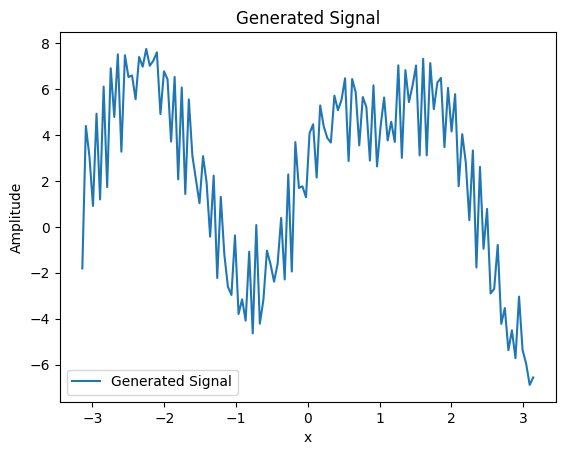

In [32]:
plt.plot(x, generated_signal, label='Generated Signal')
plt.title('Generated Signal')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [10]:
print(generated_signal)

[ 6.017057   -3.7473211  -3.7699559   4.3745875   5.3567767   5.672146
 -0.621851    5.2058935   0.36788607 -1.742967    4.9365964   6.698516
  7.051835   -1.4842271   6.384139    7.019278    0.23725533  6.3624587
  8.096369   -0.7362393  -0.61982673  7.240876    7.2338147   7.361887
  7.429068    7.4335566   7.3304367   7.2815127   7.841049   -1.3752413
  6.6949      7.3483567   7.6016936  -0.7977345   6.76259    -0.8418369
  6.685787   -0.46215492 -2.3471696   4.8104706  -2.2084258   4.7746844
  4.5902066   5.499017    5.406509   -4.0420127   3.8682494  -2.786542
 -4.259643    2.847216   -3.2264     -4.1683874   2.2517438   4.195673
 -3.9107323   2.6988292  -3.0057852  -4.433805   -4.195891    3.3888464
  4.8320446  -3.6099207  -4.1587825   3.7141874   4.6619763   4.8798666
 -2.315091    4.0869217  -1.2097412   4.6589003   5.7981763  -2.7762685
  4.792074    5.9196234   5.894581    4.4992085  -3.2685914   4.033848
  5.4157677   4.3265038  -3.9906242   2.8336687  -3.779333    2.520400